In [1]:
import MPPIController
import numpy as np
import time
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.integrate import odeint
import os
from pathlib import Path

plt.style.use(["science", "grid"])

In [2]:
import tensorflow as tf

2023-04-19 03:03:08.629621: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Inverted pendulum
Try MPPI controller with neural network dynamics model on an inverted pendulum.

In [3]:
# Get neural network model loaded
model_path = Path(os.getcwd()).parent / "neural_networks" / "inverted_pendulum" / "models"
availible_models = [x for x in model_path.iterdir() if x.is_dir()]

for (i, model_name) in enumerate(availible_models):
    print("[{}]  {}".format(i, model_name))

idx = int(input("Select which model number to load: "))
nn_model = tf.keras.models.load_model(availible_models[idx])

[0]  /Users/micahreich/Documents/16711-final-project/neural_networks/inverted_pendulum/models/inverted_pendulum_model_16nodes_18-04-2023 04:50:54
[1]  /Users/micahreich/Documents/16711-final-project/neural_networks/inverted_pendulum/models/inverted_pendulum_model_32nodes_19-04-2023 02:39:33
Select which model number to load: 0


2023-04-19 03:03:15.523665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
class InvertedPendulum:
    def __init__(self, initial_state, m, l, b, g, dt):
        self.initial_state = initial_state
        self.desired_state = None
        self.m = m
        self.l = l
        self.b = b
        self.g = g
        self.dt = dt
        self.nx, self.nu = (2, 1)
        self.NULL_ACTION  = np.zeros(self.nu)
                        
        self.controller = MPPIController.MPPIController(
            n_rollouts=200,
            horizon_length=10,
            exploration_cov=np.diag([1.5 ** 2]),
            exploration_lambda=1e-3,
            nx=self.nx,
            nu=self.nu,
            terminal_cost=self.terminal_cost,
            state_cost=self.state_cost,
            evolve_state=self.evolve_state,
            dt=dt,
            control_range={"min": np.array([-10]), "max": np.array([10])},
            control_noise_initialization = MPPIController.ControlNoiseInit.LAST,
            nn_dynamics = True
        )
        
        self.measurement_noise_cov = np.array([
            [(3 * np.pi / 180) ** 2]  # 5 degrees of measurement noise
        ])
            
    def terminal_cost(self, x):
        error = (self.desired_state - x)
        Q = np.diag([1, 1])
        
        return error.T @ Q @ error

    def state_cost(self, x):
        error = (self.desired_state - x)
        Q = np.diag([3, 1])
        
        return error.T @ Q @ error

    def evolve_state(self, nn_input):
        return nn_model(nn_input).numpy()
    
    def simulator(self, x, u, measurement_noise=False):
        def dynamics(u):
            def dydt(y, t):
                theta, omega = y
                alpha = (-self.b * omega + u[0] + self.m * self.g * self.l * np.sin(theta)) / (self.m * self.l**2)

                return np.array([omega, alpha])
            return dydt
        
        dynamics_ode = dynamics(u)
        next_state = odeint(dynamics_ode, x, np.array([0, self.dt]))[1]
        
        if measurement_noise:
            noise = np.random.multivariate_normal(np.zeros_like(u), cov=self.measurement_noise_cov,
                                                  size=1)[0]
            next_state += noise
        
        return next_state

In [53]:
dt = 1 / 10

inv_pend_env = InvertedPendulum(
    initial_state=np.array([0, 0]),
    m=1,     # kg
    l=1,     # m
    b=0.1,   # ?
    g=-9.81, # m / s^2
    dt=dt    # s
)

inv_pend_env.desired_state = np.array([np.radians(180), 0])

### Neural Network vs. Ground Truth (Natural Dynamics)
Test the neural network dynamics model with the natural dynamics of the system before using it in the controller

In [162]:
# Test the neural network dynamics on the system's natural dynamics

initial_state = np.array([np.pi-1e-3, 0])

nn_current_state = initial_state
truth_current_state = initial_state
action = np.array([0])

simulation_length = 5
n_steps = int((1 / dt) * simulation_length)

# Simulate the ground truth pendulum

def dydt(y, t):
    m, l, b, g = inv_pend_env.m, inv_pend_env.l, inv_pend_env.b, inv_pend_env.g
    theta, omega = y
    alpha = (-b * omega + m * g * l * np.sin(theta)) / (m * l**2)

    return np.array([omega, alpha])
        
truth_states = odeint(dydt, truth_current_state,
                      np.linspace(0, simulation_length, int(simulation_length/dt)))


# Simulate the neural network pendulum
nn_states = np.empty((n_steps, 2))

for i in range(n_steps):
    nn_states[i] = nn_current_state
    
    nn_input = np.hstack((nn_current_state, action))
    nn_current_state = nn_model(nn_input).numpy()[0]

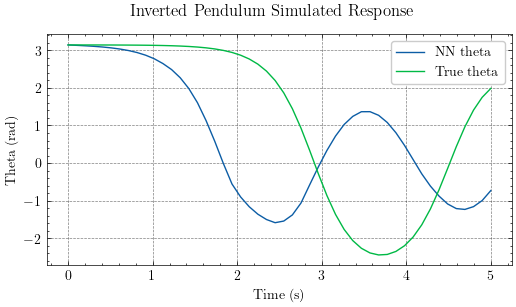

In [163]:
# Plot the simulated response

time = np.linspace(0, simulation_length, n_steps)

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
fig.suptitle("Inverted Pendulum Simulated Response")

ax.plot(time, nn_states[:, 0], label="NN theta")
ax.plot(time, truth_states[:, 0], label="True theta")

ax.set(xlabel="Time (s)", ylabel="Theta (rad)")
ax.set_ylim([-np.pi-0.3, np.pi+0.3])
ax.legend()

fig.savefig("nn_vs_true_theta_iv.png")

### MPPI Swing Up Task
Test the MPPI controller on a swing-up task using the neural network dynamics model for rollouts.

In [54]:
simulation_length = 5  # s
n_steps = int((1 / dt) * simulation_length)

# Create lists to store control sequence and state sequences for MPPI runs
controls, states = np.empty((n_steps, inv_pend_env.nu)), np.empty((n_steps, inv_pend_env.nx))

# Begin simulation
current_state = inv_pend_env.initial_state
start_time = perf_counter()

for i in range(0, n_steps):
    action = inv_pend_env.controller.step(current_state)
    current_state = inv_pend_env.simulator(current_state, action, measurement_noise=False)
    
    states[i] = current_state
    controls[i] = action

print("Elapsed Time: {:.5f} s".format(perf_counter() - start_time))

Elapsed Time: 1.80424 s


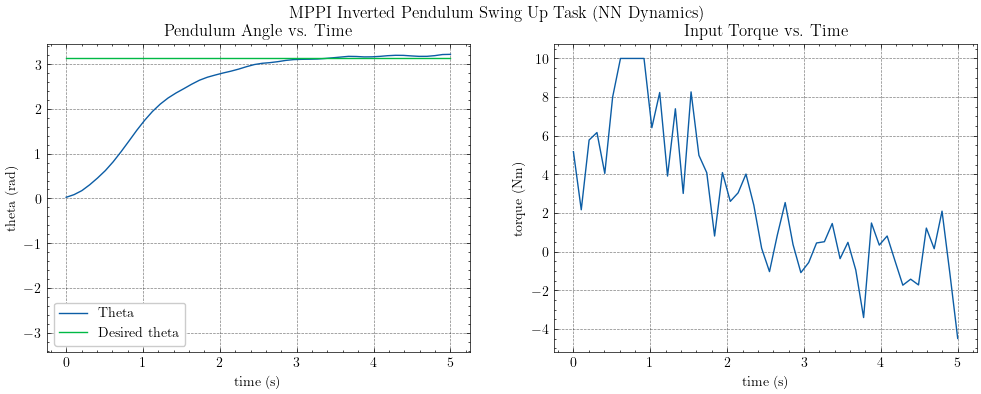

In [55]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

fig.suptitle("MPPI Inverted Pendulum Swing Up Task (NN Dynamics)")

time = np.linspace(0, simulation_length, n_steps)

ax1.set_title("Pendulum Angle vs. Time")
ax1.plot(time, states[:, 0], label="Theta")
ax1.plot(time, np.repeat(inv_pend_env.desired_state[0], n_steps), label="Desired theta")
ax1.set(xlabel="time (s)", ylabel="theta (rad)")
ax1.set_ylim([-np.pi-0.3, np.pi+0.3])
ax1.legend()

ax2.set_title("Input Torque vs. Time")
ax2.plot(time, controls[:, 0], label="Input torque")
ax2.set(xlabel="time (s)", ylabel="torque (Nm)")

fig.savefig("swingup_task.png")